# Clustering Toronto neighborhood data
capstone / week 3

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

This is a list of postal codes in Canada where the first letter is M. Postal codes beginning with M are located within the city of Toronto in the province of Ontario. Only the first three characters are listed, corresponding to the Forward Sortation Area.

In [3]:
#wikipedia
url_html = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

# ---------------- QUESTION 1: Scrapping webpage for Toronto -------------------------------------------

In [4]:
# read the postal codes
dfs = pd.read_html(url_html)
len(dfs)
toronto_neighbourhoods = dfs[0]
toronto_neighbourhoods.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [5]:
toronto_neighbourhoods.describe()

,Postcode,Borough,Neighbourhood
count,287,287,287
unique,180,12,208
top,M8Y,Not assigned,Not assigned
freq,8,77,78


In [6]:
toronto_neighbourhoods.replace(np.nan, "Not assigned", inplace=True)
toronto_neighbourhoods.columns

Index(['Postcode', 'Borough', 'Neighbourhood'], dtype='object')

In [7]:
# primary shape of the dataset
toronto_neighbourhoods.shape

(287, 3)

In [58]:
toronto_neighbourhoods.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## Cleaning/preparing the data for Toronto

In [9]:
# Remove the 'Not assigned' rows as they are useless
df = toronto_neighbourhoods
toronto_df = df[ (df['Borough'] != 'Not assigned')]
toronto_df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [10]:
# group the Neighbourhood by Postcode
df_joined_neighbourhood = toronto_df.groupby('Postcode').Neighbourhood.agg( [('Neighbourhood', ','.join) ])
df_joined_neighbourhood.reset_index(inplace=True)
df_joined = pd.merge(df_joined_neighbourhood, toronto_df[['Postcode','Borough']], on='Postcode')
df_joined.drop_duplicates(inplace=True)
df_joined.head()

,Postcode,Neighbourhood,Borough
0,M1B,"Rouge,Malvern",Scarborough
2,M1C,"Highland Creek,Rouge Hill,Port Union",Scarborough
5,M1E,"Guildwood,Morningside,West Hill",Scarborough
8,M1G,Woburn,Scarborough
9,M1H,Cedarbrae,Scarborough


In [11]:
# update "Not assigned" Neighbourhood with the Borough
df_joined['Neighbourhood'].replace('Not assigned', df_joined['Borough'],inplace=True)
# verify that there is no more 'Not assigned' borough
df_joined[ (df_joined['Neighbourhood'] == 'Not assigned') | (df_joined['Borough'] == 'Not assigned')] 

,Postcode,Neighbourhood,Borough


## Final Toronto data set content and shape

In [12]:
df_joined.head()

,Postcode,Neighbourhood,Borough
0,M1B,"Rouge,Malvern",Scarborough
2,M1C,"Highland Creek,Rouge Hill,Port Union",Scarborough
5,M1E,"Guildwood,Morningside,West Hill",Scarborough
8,M1G,Woburn,Scarborough
9,M1H,Cedarbrae,Scarborough


In [14]:
df_toronto_neigh = df_joined
df_toronto_neigh.shape

(103, 3)

# ------------- QUESTION 2: latitude and the longitude coordinates of each neighborhood --------

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. 

In [15]:
# get the geospatial data
url_ll = 'http://cocl.us/Geospatial_data'
df_ll = pd.read_csv(url_ll)
df_ll.rename({'Postal Code':'Postcode'}, axis='columns', inplace=True)
df_ll.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Toronto postal codes with latitude and longitude

In [16]:
df_neigh_ll = pd.merge(df_toronto_neigh, df_ll, on='Postcode')
df_neigh_ll.head()

,Postcode,Neighbourhood,Borough,Latitude,Longitude
0,M1B,"Rouge,Malvern",Scarborough,43.806686,-79.194353
1,M1C,"Highland Creek,Rouge Hill,Port Union",Scarborough,43.784535,-79.160497
2,M1E,"Guildwood,Morningside,West Hill",Scarborough,43.763573,-79.188711
3,M1G,Woburn,Scarborough,43.770992,-79.216917
4,M1H,Cedarbrae,Scarborough,43.773136,-79.239476


In [17]:
# verify that there is no empty Lat and Long and that the join went well.
df_neigh_ll.dropna().shape 

(103, 5)

In [18]:
df_neigh_ll['Borough'].value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           11
Central Toronto      9
West Toronto         6
York                 5
East York            5
East Toronto         5
Queen's Park         1
Mississauga          1
Name: Borough, dtype: int64

# ------------- QUESTION 3:Explore and cluster the neighborhoods in Toronto.  ----------------------

Explore and cluster the neighborhoods in Toronto. 
You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you. 
Just make sure:
- to add enough Markdown cells to explain what you decided to do and to report any observations you make.
- to generate maps to visualize your neighborhoods and how they cluster together. 

### Filter on Toronto downton city only

In [19]:
toronto_data = df_neigh_ll [ df_neigh_ll['Borough'].str.contains('Downtown Toronto')]
toronto_data.head()

,Postcode,Neighbourhood,Borough,Latitude,Longitude
50,M4W,Rosedale,Downtown Toronto,43.679563,-79.377529
51,M4X,"Cabbagetown,St. James Town",Downtown Toronto,43.667967,-79.367675
52,M4Y,Church and Wellesley,Downtown Toronto,43.665860,-79.383160
53,M5A,Harbourfront,Downtown Toronto,43.654260,-79.360636
54,M5B,"Ryerson,Garden District",Downtown Toronto,43.657162,-79.378937


Let's create a function to repeat the same process to all the neighborhoods in Toronto

### call 4Square API to get venues in a radius around the center of a each neighbourhood

In [20]:
# foursquare crendentials
CLIENT_ID = 'JMXA0VAYNSTYQ5NHWZGRB1GOUI0QEEWVEOD5YZFDU1ZVJL5O' # your Foursquare ID
CLIENT_SECRET = 'KV2YRAJYADPIFDDBK5AWDE41F1OJAEA5EDMKTQL23GU0AXW2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 400 # define radius

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [21]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighbourhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Queen's Park


In [22]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
1,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
2,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
3,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail
4,"Cabbagetown,St. James Town",43.667967,-79.367675,Cranberries,43.667843,-79.369407,Diner


In [23]:
# get the number of venues in Toronto
print(toronto_venues.shape)

(1278, 7)


In [24]:
# how many venues per neighboorhood do we have ?
toronto_venues.groupby('Neighborhood')['Venue Category'].count().head()

Neighborhood
Adelaide,King,Richmond                                                                                  100
Berczy Park                                                                                              56
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara     14
Cabbagetown,St. James Town                                                                               43
Central Bay Street                                                                                       84
Name: Venue Category, dtype: int64

In [25]:
print('There are {} uniques venue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 207 uniques venue categories.


### Get line for each venue alongwith its category as dummy columns

In [26]:
# one hot encoding for each category
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['YNeighborhood'] = toronto_venues['Neighborhood'] 

toronto_onehot.columns[-1]

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.rename(columns={'YNeighborhood': 'TheNeighborhood'}, inplace=True)

toronto_onehot.head()

,TheNeighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
toronto_onehot.shape

(1278, 208)

In [28]:
# move to one line per neighborhood with all the venue types and amount (mean)
toronto_grouped = toronto_onehot.groupby('TheNeighborhood').mean().reset_index()
toronto_grouped.head()

,TheNeighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.0,0.0,0.010000,0.0,0.03,0.0,0.000000,0.0,0.000000,0.030000,0.000000,0.03000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.010000,0.000000,0.01,0.010000,0.0,0.00000,0.01,0.030000,0.01,0.000000,0.050000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.070000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.0,0.02,0.000000,0.01,0.0,0.010000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.00000,0.000000,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.000000,0.000000,0.020000,0.01000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.000000,0.01000,0.000000,0.0,0.01,0.0,0.000000,0.010000,0.000000,0.0,0.01,0.0,0.000000,0.0,0.000000,0.000000,0.010000,0.0,0.01,0.0,0.000000,0.0,0.01,0.01,0.0,0.01,0.010000,0.01,0.0,0.0,0.0,0.010000,0.0,0.0,0.000000,0.000000,0.020000,

In [30]:
# How many neighbohood do we have ?
toronto_grouped.shape

(18, 208)

In [31]:
# Let's print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['TheNeighborhood'].head():
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['TheNeighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
              venue  freq
0       Coffee Shop  0.07
1              Café  0.05
2        Steakhouse  0.04
3   Thai Restaurant  0.04
4  Asian Restaurant  0.03


----Berczy Park----
         venue  freq
0  Coffee Shop  0.09
1       Bakery  0.04
2   Steakhouse  0.04
3         Café  0.04
4  Cheese Shop  0.04


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3          Boutique  0.07
4           Airport  0.07


----Cabbagetown,St. James Town----
                venue  freq
0         Coffee Shop  0.07
1         Pizza Place  0.05
2                 Pub  0.05
3              Bakery  0.05
4  Italian Restaurant  0.05


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.14
1  Italian Restaurant  0.05
2      Ice Cream Shop  0.04
3                Café  0.04
4      Sandwich Place  0

### Build/display the top 10 venues in each neighborhood of Toronto.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['TheNeighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['TheNeighborhood'] = toronto_grouped['TheNeighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,TheNeighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Thai Restaurant,Steakhouse,Bakery,Bar,Sushi Restaurant,Asian Restaurant,Salad Place,Burger Joint
1,Berczy Park,Coffee Shop,Farmers Market,Cocktail Bar,Seafood Restaurant,Bakery,Steakhouse,Café,Cheese Shop,Beer Bar,Clothing Store
2,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Boutique,Coffee Shop,Plane,Sculpture Garden,Boat or Ferry,Airport
3,"Cabbagetown,St. James Town",Coffee Shop,Pub,Park,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Bubble Tea Shop,Salad Place,Fried Chicken Joint


### Cluster Neighborhoods with k-mean modeling of downtown Toronto only

In [34]:
# drop the first column as it is useless for the clustering
toronto_grouped_clustering = toronto_grouped.drop('TheNeighborhood', 1)

In [37]:
# 
# find the best k (number of clusters) regarding the inertia_ score
#
Ks = 7 # number of ks we will test
inertias = np.zeros((Ks-1))
for n in range(1,Ks):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0, n_init = 12).fit(toronto_grouped_clustering)
    inertias[n-1] = kmeans.inertia_

# display the inertia    
inertias

array([0.73573246, 0.3839127 , 0.28013311, 0.20142188, 0.16373844,
       0.14122478])

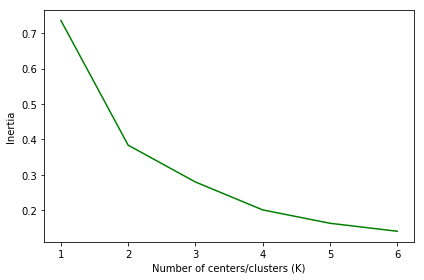

In [38]:
# 
# plot the inertia with the different k to find the better balance
#
plt.plot(range(1,Ks),inertias,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

In [41]:
# I decide to choose 5 as it is a good balance between clutering reability and inertia score
kmeans = KMeans(n_clusters=5, random_state=0, n_init = 12).fit(toronto_grouped_clustering)
kmeans.labels_[0:40] 

array([1, 1, 0, 1, 1, 3, 4, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1], dtype=int32)

In [42]:
# Display the information on the centers
print("number of clusters:", len(kmeans.cluster_centers_))
#print("cluster center:" , kmeans.cluster_centers_)
print("number of iterations:", kmeans.n_iter_)
print("inertia (Sum of squared distances of samples to cluster center): ", kmeans.inertia_)

number of clusters: 5
number of iterations: 2
inertia (Sum of squared distances of samples to cluster center):  0.16373843743712296


Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood AND the latitude and longiture to be able to put them on the map.

In [43]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.astype({'Cluster Labels':'int32'},copy=False)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(neighborhoods_venues_sorted.set_index('TheNeighborhood'), how='left', right_on='TheNeighborhood', left_on='Neighbourhood')

In [44]:
# drop "queen's park" as there is no venue as far as I can see
toronto_merged = toronto_merged[ toronto_merged['Neighbourhood'] != "Queen\'s Park"]
toronto_merged.head()

,Postcode,Neighbourhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Rosedale,Downtown Toronto,43.679563,-79.377529,2.0,Park,Playground,Trail,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant
1,M4X,"Cabbagetown,St. James Town",Downtown Toronto,43.667967,-79.367675,1.0,Coffee Shop,Pub,Park,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
2,M4Y,Church and Wellesley,Downtown Toronto,43.665860,-79.383160,1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Café,Gastropub,Pub,Hotel,Gym
3,M5A,Harbourfront,Downtown Toronto,43.654260,-79.360636,1.0,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Event Space
4,M5B,"Ryerson,Garden District",Downtown Toronto,43.657162,-79.378937,1.0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Tea Room,Diner,Bakery,Pizza Place


In [45]:
# display the number of borough per cluster
toronto_merged['Cluster Labels'].value_counts()

1.0    13
3.0     2
4.0     1
0.0     1
2.0     1
Name: Cluster Labels, dtype: int64

### Visualize cluster on the map

In [46]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of toronto are 43.653963, -79.387207.


In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(len(toronto_merged['Cluster Labels'].value_counts()))
ys = [i + x + (i*x)**2 for i in range(len(toronto_merged['Cluster Labels'].value_counts()))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
count=0

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + '/ Cluster is ' + str(cluster), parse_html=True)  
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Assign a name or a flavor to each cluster

### Cluster 1 : airport and marina

In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.0,Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Boutique,Coffee Shop,Plane,Sculpture Garden,Boat or Ferry,Airport


### Cluster 2: Restaurants and leisure places

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Cabbagetown,St. James Town",1.0,Coffee Shop,Pub,Park,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
2,Church and Wellesley,1.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Café,Gastropub,Pub,Hotel,Gym
3,Harbourfront,1.0,Coffee Shop,Park,Pub,Bakery,Theater,Breakfast Spot,Restaurant,Café,Mexican Restaurant,Event Space
4,"Ryerson,Garden District",1.0,Coffee Shop,Clothing Store,Cosmetics Shop,Café,Fast Food Restaurant,Middle Eastern Restaurant,Tea Room,Diner,Bakery,Pizza Place
5,St. James Town,1.0,Coffee Shop,Café,Restaurant,Clothing Store,Hotel,Cosmetics Shop,American Restaurant,Diner,Italian Restaurant,Breakfast Spot
6,Berczy Park,1.0,Coffee Shop,Farmers Market,Cocktail Bar,Seafood Restaurant,Bakery,Steakhouse,Café,Cheese Shop,Beer Bar,Clothing Store
7,Central Bay Street,1.0,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Bubble Tea Shop,Salad Place,Fried Chicken Joint
8,"Adelaide,King,Richmond",1.0,Coffee Shop,Café,Thai Restaurant,Steakhouse,Bakery,Bar,Sushi Restaurant,Asian Restaurant,Salad Place,Burger Joint
9,"Harbourfront East,Toronto Islands,Union Station",1.0,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Brewery,Scenic Lookout,Restaurant,Fried Chicken Joint,Pizza Place
10,"Design Exchange,Toronto Dominion Centre",1.0,Coffee Shop,Café,Restaurant,Hotel,Bar,American Restaurant,Bakery,Deli / Bodega,Steakhouse,Seafood Restaurant


### Cluster 3: park and outdoor facilities

In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Rosedale,2.0,Park,Playground,Trail,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop,Doner Restaurant


### Cluster 4: café, café

In [56]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Harbord,University of Toronto",3.0,Café,Bookstore,Restaurant,Bar,Italian Restaurant,Japanese Restaurant,Sandwich Place,Bakery,Beer Bar,Beer Store
13,"Chinatown,Grange Park,Kensington Market",3.0,Café,Bar,Dumpling Restaurant,Vietnamese Restaurant,Bakery,Mexican Restaurant,Chinese Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Dessert Shop


### Cluster 5: grosery, park and night club

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Christie,4.0,Grocery Store,Café,Park,Nightclub,Diner,Restaurant,Italian Restaurant,Candy Store,Athletics & Sports,Baby Store
